In [1]:
import math
import copy
import random
from turtle import forward
from typing import Optional, Tuple, List, Union

import torch
from torch import Tensor, nn

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from transformers import EvalPrediction
import numpy as np

/opt/homebrew/Caskroom/miniforge/base/envs/transformers_dev/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Differentiable TopK-Pooling

At each layer only $k$ token-embeddings are selected and passed to the next layer.

To make this operation differentiable it cannot use a hard selection scheme.

The authors propose a an algorithm which uses two steps:

1. Sorting
   * The embeddings passed into the current layer are scored using a linear operation (e.g. dot product)
   * The embeddings get sorted according to their score
   * Question: Sorting is a non-differentiable or partially non-differentiable?
   * Note: After selection the embeddings are re-arranged according to their original order????? This does not make any sense since they are positionally encoded???

In [2]:
x = torch.randint(0, 1000, (16, 512, 128))

In [3]:
torch.sort(x).indices

tensor([[[ 24, 119, 122,  ...,  58,  28,   2],
         [  4,  77,  96,  ...,  84,  32,  97],
         [  4, 122,  84,  ...,  62,  10,  49],
         ...,
         [100, 112,  77,  ...,   1, 116,  92],
         [ 12, 104,  22,  ...,  83,  85,  29],
         [ 99,  23,  45,  ..., 117,  43,   1]],

        [[ 16,   8,  53,  ...,  69,  93,  65],
         [  6, 127,  34,  ..., 117,  78,  99],
         [ 38,  12,  61,  ...,  63,   9,  79],
         ...,
         [  7,  11, 117,  ...,  26,  74, 123],
         [ 46, 126,  83,  ...,  15,   3,  97],
         [ 42,  90,  24,  ...,  39,  58,  94]],

        [[  0,  26,  37,  ...,  78, 106,   6],
         [ 47,  27,  11,  ...,   0, 104,  73],
         [ 25,  80,  16,  ...,  46,  41,  96],
         ...,
         [ 36,  12, 112,  ..., 117,  39,  29],
         [ 72,  59,  48,  ...,  93,  68, 117],
         [ 71,  90, 125,  ...,  40,  14,  41]],

        ...,

        [[ 13,  94,  79,  ...,  61, 108,  15],
         [ 39, 123,  17,  ..., 122,  44, 112]

In [4]:
def peaked_softmax(x: Tensor, alpha: float = 0.1, dim: int = 0):
    x = x * alpha
    softmax = nn.Softmax(dim=dim)
    return softmax(x)


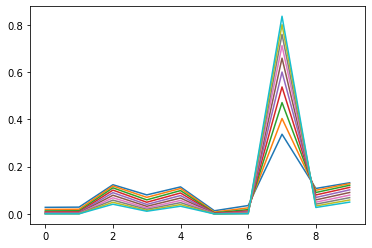

In [5]:
x = torch.randn(10)
for i in torch.linspace(1, 3, 10):
    plt.plot(peaked_softmax(x, alpha=i.item()).numpy())

In [6]:
class TopKPooler(nn.Module):

    def __init__(self, embedding_dim: int) -> None:
        super().__init__()
        self.scorer = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, embeddings: Tensor):
        """_summary_

        Args:
            embeddings (Tensor): tensor of shape (batch_size, n_embeddings,
        """
        # 1. Score embeddings
        scores = self.scorer(embeddings)
        
        # 2. Sort embeddings according to their score in descending order
        embeddings_sorted, scores_sorted = self.sort_embeddings(embeddings=embeddings, scores=scores)

        # 3. Create new tensors with pairs of embeddings and scores
        # Create embeddings pairs

        middle_idx = int(embeddings.size(1) // 2)
        #print(middle_idx)

        left_embeddings, right_embeddings = embeddings_sorted[:, :middle_idx, :], embeddings_sorted[:, middle_idx:, :]
        embedding_pairs = torch.cat((left_embeddings.unsqueeze(3), right_embeddings.flip(1).unsqueeze(3)), dim=3)
        #print(embedding_pairs.size())  # shape: bs, seqlen // 2, n_dim, 2

        # Create score pairs

        left_scores, right_scores = scores_sorted[:, :middle_idx, :], scores_sorted[:, middle_idx:, :]
        score_pairs = torch.cat((left_scores.unsqueeze(3), right_scores.flip(1).unsqueeze(3)), dim=3)
        #print(score_pairs.size())  # shape: bs, seqlen // 2, 1, 2

        score_pairs_softmaxed = peaked_softmax(score_pairs, alpha=5.0, dim=3)
        #print(score_pairs_softmaxed.size())

        new_embeddings = (embedding_pairs * score_pairs_softmaxed).sum(dim=3)
        #print(new_embeddings.size())
        return new_embeddings    
    
    def sort_embeddings(self, embeddings: Tensor, scores: Tensor):
        """Sorts the embeddings and score according to their score in descending order

        Args:
            embeddings (Tensor): tensor of shape (batch_size, n_embeddings, n_dims)
            scores (Tensor): (batch_size, n_embeddings, 1)

        Returns:
            _type_: Sorted embeddings and scores
        """
        sort_idc = scores.sort(descending=True, dim=1).indices
        #print(sort_idc.size())
        
        embeddings_sorted = self.sort_by_indices(embeddings, sort_idc)  #???
        #print(embeddings_sorted.size())
        
        scores_sorted = self.sort_by_indices(scores, sort_idc)  #???
        #print(scores_sorted.size())
        
        return embeddings_sorted, scores_sorted
    
    @staticmethod
    def sort_by_indices(embeddings, indices):
        sorted_batches = []
        for batch_embeddings, batch_scores in zip(embeddings, indices):
            sorted_batches.append(batch_embeddings[batch_scores.reshape(-1)].unsqueeze(0))
        return torch.cat(sorted_batches, dim=0)

            

In [7]:
n_layers = torch.log2(torch.tensor(512)).long().item()

pyramid = nn.Sequential(*(
    TopKPooler(embedding_dim=768)
    for _ in range(n_layers)
))
pyramid

Sequential(
  (0): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (1): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (2): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (3): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (4): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (5): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (6): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (7): TopKPooler(
   

In [8]:
src = torch.randn(8, 512, 768)
trgt = src[:, 64, :]
print(src.size())
print(trgt.size())

torch.Size([8, 512, 768])
torch.Size([8, 768])


In [9]:
out = pyramid(src)
out.size()

torch.Size([8, 1, 768])

In [10]:
optim = torch.optim.SGD(params=pyramid.parameters(), lr=0.1)
pbar = tqdm(list(range(10)))
for _ in pbar:
    out = pyramid(src).squeeze(1)
    loss_fct = nn.MSELoss()
    loss = loss_fct(out, trgt)
    pbar.set_description(f"Loss: {round(loss.item(), 4)}")
    loss.backward()
    optim.step()
    optim.zero_grad()


Loss: 0.9856: 100%|██████████| 10/10 [00:00<00:00, 19.51it/s]


In [11]:
out = pyramid(src).squeeze(1)
print(out)
print(trgt)

tensor([[-0.0332, -0.0208,  0.0702,  ..., -0.0905, -0.0324, -0.0400],
        [-0.0128, -0.0196,  0.0409,  ..., -0.0531, -0.0166,  0.0094],
        [ 0.1158, -0.1732, -0.1092,  ...,  0.0111, -0.0612,  0.0165],
        ...,
        [ 0.0234, -0.0765,  0.1523,  ..., -0.0476, -0.0183,  0.0464],
        [-0.0643,  0.0276,  0.0675,  ..., -0.0098, -0.0119, -0.0564],
        [ 0.1530, -0.0729, -0.0031,  ...,  0.0888, -0.0047, -0.1614]],
       grad_fn=<SqueezeBackward1>)
tensor([[-0.1942,  0.6379, -0.3457,  ..., -1.0045, -0.4812,  0.9927],
        [ 0.7160,  1.1301,  0.3286,  ...,  0.2789,  0.9490, -0.4316],
        [-0.5369,  1.6008, -1.8433,  ..., -0.8403, -0.2150,  0.2143],
        ...,
        [-0.0837, -0.5883,  0.9293,  ...,  0.0957, -0.9959, -0.0143],
        [ 0.9582, -0.5126,  2.0424,  ...,  0.5452,  0.4282, -0.7062],
        [ 1.0666, -0.6540, -0.9030,  ...,  1.7305,  0.5118, -0.8643]])


In [12]:
trgt

tensor([[-0.1942,  0.6379, -0.3457,  ..., -1.0045, -0.4812,  0.9927],
        [ 0.7160,  1.1301,  0.3286,  ...,  0.2789,  0.9490, -0.4316],
        [-0.5369,  1.6008, -1.8433,  ..., -0.8403, -0.2150,  0.2143],
        ...,
        [-0.0837, -0.5883,  0.9293,  ...,  0.0957, -0.9959, -0.0143],
        [ 0.9582, -0.5126,  2.0424,  ...,  0.5452,  0.4282, -0.7062],
        [ 1.0666, -0.6540, -0.9030,  ...,  1.7305,  0.5118, -0.8643]])

In [13]:
torch.randn(16, 512, 1).squeeze(2).size()

torch.Size([16, 512])

In [14]:
e = torch.tensor([
    [
        [0.1, 1.9],
        [0.0, 0.5],
        [0.7, 0.9]
    ],
    [
        [0.0, 0.0],
        [0.0, 0.5],
        [0.7, 0.9]
    ]
])
print(e.size())

s = torch.tensor([
    [
        [0],
        [2],
        [1]
    ],
    [
        [2],
        [1],
        [0]
    ],
])
print(s.size())

torch.Size([2, 3, 2])
torch.Size([2, 3, 1])


In [15]:
torch.arange(10).repeat(2).reshape(2, -1).flip(1)

tensor([[9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
        [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]])

# Model Architecture

* Pyramdion only serves as encoder model?
* Which architecture to use for decoder?

In [16]:
from transformers import PyramidionsConfig, PyramidionsModel, RobertaTokenizer, PyramidionsForSequenceClassification

In [17]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [18]:
position_ids = torch.arange(
            1 + 1, 512 + 1 + 1, dtype=torch.long)

In [19]:
position_ids

tensor([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 1

In [20]:
config = PyramidionsConfig()
config.update({"num_hidden_layers": 9, "max_position_embeddings": 514, "type_vocab_size": 2, "type_vocab_size": 1})
print(config)
model = PyramidionsForSequenceClassification(config)

model.resize_token_embeddings(len(tokenizer))

PyramidionsConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "pyramidions",
  "num_attention_heads": 12,
  "num_hidden_layers": 9,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30522
}



Embedding(50265, 768)

In [21]:
outputs = model(**tokenizer("Hallo", padding="max_length", return_tensors="pt"))
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[0.2860, 0.6765]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [22]:
from transformers import RobertaModel

pretrained_model = RobertaModel.from_pretrained("roberta-base")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
from collections import OrderedDict
def rename_roberta_state_dict(state_dict):
    return OrderedDict([(f"pyramidions.{key}", value) for key, value in state_dict.items()])

In [24]:
model.load_state_dict(rename_roberta_state_dict(pretrained_model.state_dict()), strict=False)

_IncompatibleKeys(missing_keys=['pyramidions.encoder.layer.0.pooler.scorer.0.weight', 'pyramidions.encoder.layer.0.pooler.scorer.0.bias', 'pyramidions.encoder.layer.1.pooler.scorer.0.weight', 'pyramidions.encoder.layer.1.pooler.scorer.0.bias', 'pyramidions.encoder.layer.2.pooler.scorer.0.weight', 'pyramidions.encoder.layer.2.pooler.scorer.0.bias', 'pyramidions.encoder.layer.3.pooler.scorer.0.weight', 'pyramidions.encoder.layer.3.pooler.scorer.0.bias', 'pyramidions.encoder.layer.4.pooler.scorer.0.weight', 'pyramidions.encoder.layer.4.pooler.scorer.0.bias', 'pyramidions.encoder.layer.5.pooler.scorer.0.weight', 'pyramidions.encoder.layer.5.pooler.scorer.0.bias', 'pyramidions.encoder.layer.6.pooler.scorer.0.weight', 'pyramidions.encoder.layer.6.pooler.scorer.0.bias', 'pyramidions.encoder.layer.7.pooler.scorer.0.weight', 'pyramidions.encoder.layer.7.pooler.scorer.0.bias', 'pyramidions.encoder.layer.8.pooler.scorer.0.weight', 'pyramidions.encoder.layer.8.pooler.scorer.0.bias', 'classifier.de

In [25]:
from datasets import load_dataset

dataset = load_dataset("imdb")

Reusing dataset imdb (/Users/lennartkeller/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|██████████| 3/3 [00:00<00:00, 908.51it/s]


In [26]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [27]:
dataset = dataset.map(lambda row: tokenizer(row["text"], truncation=True))

Loading cached processed dataset at /Users/lennartkeller/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-54aedbefd2676f9d.arrow
Loading cached processed dataset at /Users/lennartkeller/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-837877adeb715f8d.arrow
Loading cached processed dataset at /Users/lennartkeller/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-7a2499041269e44e.arrow


In [28]:
dataset.set_format("torch")
dataset.rename_column("label", "labels")
dataset.remove_columns("text")

dataset = dataset["train"].train_test_split(test_size=0.15, seed=42)["test"]
dataset = dataset.train_test_split(test_size=0.05, seed=42)
dataset

Loading cached split indices for dataset at /Users/lennartkeller/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-fbe91050e3d66a64.arrow and /Users/lennartkeller/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-356559fca645c6ee.arrow
Loading cached split indices for dataset at /Users/lennartkeller/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-71955fa8d9f973c9.arrow and /Users/lennartkeller/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5d0a255d00574d45.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2375
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 125
    })
})

In [29]:

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [31]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
# I think that the trainer is not using the right padding strategy....

training_args = TrainingArguments(
    num_train_epochs=1,
    output_dir="pyramid_classif",
    per_device_train_batch_size=8,
    learning_rate=3e-5,
    logging_strategy="steps",
    logging_steps=1,
    evaluation_strategy="steps",
    eval_steps=10
)
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=DataCollatorWithPadding(padding="max_length", tokenizer=tokenizer),
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics
)


In [32]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
/Users/lennartkeller/Uni/transformers/src/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2375
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 297
  0%|          | 1/297 [00:01<07:48,  1.58s/it]

{'loss': 0.6859, 'learning_rate': 2.98989898989899e-05, 'epoch': 0.0}


  1%|          | 2/297 [00:03<07:53,  1.60s/it]

{'loss': 0.6405, 'learning_rate': 2.97979797979798e-05, 'epoch': 0.01}


  1%|          | 3/297 [00:04<07:23,  1.51s/it]

{'loss': 0.6224, 'learning_rate': 2.96969696969697e-05, 'epoch': 0.01}


  1%|▏         | 4/297 [00:06<07:13,  1.48s/it]

{'loss': 0.9514, 'learning_rate': 2.9595959595959595e-05, 'epoch': 0.01}


  2%|▏         | 5/297 [00:07<07:02,  1.45s/it]

{'loss': 0.6967, 'learning_rate': 2.9494949494949495e-05, 'epoch': 0.02}


  2%|▏         | 6/297 [00:08<06:52,  1.42s/it]

{'loss': 0.6876, 'learning_rate': 2.9393939393939394e-05, 'epoch': 0.02}


  2%|▏         | 7/297 [00:10<06:45,  1.40s/it]

{'loss': 0.6212, 'learning_rate': 2.9292929292929294e-05, 'epoch': 0.02}


  3%|▎         | 8/297 [00:11<06:45,  1.40s/it]

{'loss': 0.6258, 'learning_rate': 2.9191919191919193e-05, 'epoch': 0.03}


  3%|▎         | 9/297 [00:12<06:40,  1.39s/it]

{'loss': 0.6763, 'learning_rate': 2.9090909090909093e-05, 'epoch': 0.03}


  3%|▎         | 10/297 [00:14<06:46,  1.41s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.8403, 'learning_rate': 2.8989898989898992e-05, 'epoch': 0.03}


                                                
  3%|▎         | 10/297 [00:19<06:46,  1.41s/it]

{'eval_loss': 0.7184760570526123, 'eval_accuracy': 0.46399998664855957, 'eval_runtime': 5.347, 'eval_samples_per_second': 23.378, 'eval_steps_per_second': 2.992, 'epoch': 0.03}


  4%|▎         | 11/297 [00:21<14:28,  3.04s/it]

{'loss': 0.6218, 'learning_rate': 2.8888888888888888e-05, 'epoch': 0.04}


  4%|▍         | 12/297 [00:22<12:02,  2.54s/it]

{'loss': 0.7624, 'learning_rate': 2.8787878787878788e-05, 'epoch': 0.04}


  4%|▍         | 13/297 [00:23<10:17,  2.17s/it]

{'loss': 0.6979, 'learning_rate': 2.8686868686868687e-05, 'epoch': 0.04}


  5%|▍         | 14/297 [00:25<09:05,  1.93s/it]

{'loss': 0.7276, 'learning_rate': 2.8585858585858587e-05, 'epoch': 0.05}


  5%|▌         | 15/297 [00:26<08:18,  1.77s/it]

{'loss': 0.6744, 'learning_rate': 2.8484848484848486e-05, 'epoch': 0.05}


  5%|▌         | 16/297 [00:27<07:44,  1.65s/it]

{'loss': 0.6553, 'learning_rate': 2.8383838383838386e-05, 'epoch': 0.05}


  6%|▌         | 17/297 [00:29<07:17,  1.56s/it]

{'loss': 0.7322, 'learning_rate': 2.8282828282828285e-05, 'epoch': 0.06}


  6%|▌         | 18/297 [00:30<07:00,  1.51s/it]

{'loss': 0.6945, 'learning_rate': 2.8181818181818185e-05, 'epoch': 0.06}


  6%|▋         | 19/297 [00:32<06:46,  1.46s/it]

{'loss': 0.6614, 'learning_rate': 2.808080808080808e-05, 'epoch': 0.06}


  7%|▋         | 20/297 [00:33<06:38,  1.44s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.6606, 'learning_rate': 2.797979797979798e-05, 'epoch': 0.07}


                                                
  7%|▋         | 20/297 [00:38<06:38,  1.44s/it]

{'eval_loss': 0.6929615139961243, 'eval_accuracy': 0.5360000133514404, 'eval_runtime': 5.4531, 'eval_samples_per_second': 22.923, 'eval_steps_per_second': 2.934, 'epoch': 0.07}


  7%|▋         | 21/297 [00:40<14:05,  3.07s/it]

{'loss': 0.6276, 'learning_rate': 2.787878787878788e-05, 'epoch': 0.07}


  7%|▋         | 22/297 [00:41<11:44,  2.56s/it]

{'loss': 0.6565, 'learning_rate': 2.777777777777778e-05, 'epoch': 0.07}


  8%|▊         | 23/297 [00:43<10:03,  2.20s/it]

{'loss': 0.7582, 'learning_rate': 2.767676767676768e-05, 'epoch': 0.08}


  8%|▊         | 24/297 [00:44<08:53,  1.95s/it]

{'loss': 0.7678, 'learning_rate': 2.7575757575757578e-05, 'epoch': 0.08}


  8%|▊         | 25/297 [00:45<08:03,  1.78s/it]

{'loss': 0.6583, 'learning_rate': 2.7474747474747478e-05, 'epoch': 0.08}


  9%|▉         | 26/297 [00:47<07:29,  1.66s/it]

{'loss': 0.6248, 'learning_rate': 2.7373737373737374e-05, 'epoch': 0.09}


  9%|▉         | 27/297 [00:48<07:04,  1.57s/it]

{'loss': 0.6675, 'learning_rate': 2.7272727272727273e-05, 'epoch': 0.09}


  9%|▉         | 28/297 [00:49<06:46,  1.51s/it]

{'loss': 0.5933, 'learning_rate': 2.7171717171717173e-05, 'epoch': 0.09}


 10%|▉         | 29/297 [00:51<06:33,  1.47s/it]

{'loss': 0.7487, 'learning_rate': 2.7070707070707072e-05, 'epoch': 0.1}


 10%|█         | 30/297 [00:52<06:25,  1.44s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.6791, 'learning_rate': 2.696969696969697e-05, 'epoch': 0.1}


                                                
 10%|█         | 30/297 [00:58<06:25,  1.44s/it]

{'eval_loss': 0.702253520488739, 'eval_accuracy': 0.4320000112056732, 'eval_runtime': 5.4563, 'eval_samples_per_second': 22.909, 'eval_steps_per_second': 2.932, 'epoch': 0.1}


 10%|█         | 31/297 [00:59<13:36,  3.07s/it]

{'loss': 0.7627, 'learning_rate': 2.686868686868687e-05, 'epoch': 0.1}


 11%|█         | 32/297 [01:00<11:17,  2.56s/it]

{'loss': 0.8576, 'learning_rate': 2.676767676767677e-05, 'epoch': 0.11}


 11%|█         | 33/297 [01:02<09:41,  2.20s/it]

{'loss': 0.6827, 'learning_rate': 2.6666666666666667e-05, 'epoch': 0.11}


 11%|█▏        | 34/297 [01:03<08:35,  1.96s/it]

{'loss': 0.6667, 'learning_rate': 2.6565656565656566e-05, 'epoch': 0.11}


 12%|█▏        | 35/297 [01:05<07:47,  1.78s/it]

{'loss': 0.7684, 'learning_rate': 2.6464646464646466e-05, 'epoch': 0.12}


 12%|█▏        | 36/297 [01:06<07:14,  1.66s/it]

{'loss': 0.7035, 'learning_rate': 2.6363636363636365e-05, 'epoch': 0.12}


 12%|█▏        | 37/297 [01:07<06:50,  1.58s/it]

{'loss': 0.7147, 'learning_rate': 2.6262626262626265e-05, 'epoch': 0.12}


 13%|█▎        | 38/297 [01:09<06:32,  1.52s/it]

{'loss': 0.7231, 'learning_rate': 2.6161616161616164e-05, 'epoch': 0.13}


 13%|█▎        | 39/297 [01:10<06:20,  1.48s/it]

{'loss': 0.6808, 'learning_rate': 2.6060606060606063e-05, 'epoch': 0.13}


 13%|█▎        | 40/297 [01:11<06:12,  1.45s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.6796, 'learning_rate': 2.595959595959596e-05, 'epoch': 0.13}


                                                
 13%|█▎        | 40/297 [01:17<06:12,  1.45s/it]

{'eval_loss': 0.6864455938339233, 'eval_accuracy': 0.5680000185966492, 'eval_runtime': 5.4298, 'eval_samples_per_second': 23.021, 'eval_steps_per_second': 2.947, 'epoch': 0.13}


 14%|█▍        | 41/297 [01:18<13:02,  3.06s/it]

{'loss': 0.6368, 'learning_rate': 2.585858585858586e-05, 'epoch': 0.14}


 14%|█▍        | 42/297 [01:20<10:51,  2.55s/it]

{'loss': 0.7312, 'learning_rate': 2.575757575757576e-05, 'epoch': 0.14}


 14%|█▍        | 43/297 [01:21<09:21,  2.21s/it]

{'loss': 0.6568, 'learning_rate': 2.5656565656565658e-05, 'epoch': 0.14}


 15%|█▍        | 44/297 [01:22<08:18,  1.97s/it]

{'loss': 0.6797, 'learning_rate': 2.5555555555555557e-05, 'epoch': 0.15}


 15%|█▌        | 45/297 [01:24<07:35,  1.81s/it]

{'loss': 0.6521, 'learning_rate': 2.5454545454545457e-05, 'epoch': 0.15}


 15%|█▌        | 46/297 [01:25<07:04,  1.69s/it]

{'loss': 0.7405, 'learning_rate': 2.5353535353535356e-05, 'epoch': 0.15}


 16%|█▌        | 47/297 [01:27<06:44,  1.62s/it]

{'loss': 0.7114, 'learning_rate': 2.5252525252525256e-05, 'epoch': 0.16}


 16%|█▌        | 48/297 [01:28<06:32,  1.58s/it]

{'loss': 0.6619, 'learning_rate': 2.5151515151515152e-05, 'epoch': 0.16}


 16%|█▋        | 49/297 [01:30<06:25,  1.55s/it]

{'loss': 0.6433, 'learning_rate': 2.505050505050505e-05, 'epoch': 0.16}


 17%|█▋        | 50/297 [01:31<06:29,  1.58s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.7274, 'learning_rate': 2.494949494949495e-05, 'epoch': 0.17}


                                                
 17%|█▋        | 50/297 [01:37<06:29,  1.58s/it]

{'eval_loss': 0.685123085975647, 'eval_accuracy': 0.5680000185966492, 'eval_runtime': 5.6542, 'eval_samples_per_second': 22.108, 'eval_steps_per_second': 2.83, 'epoch': 0.17}


 17%|█▋        | 51/297 [01:38<13:18,  3.25s/it]

{'loss': 0.7418, 'learning_rate': 2.484848484848485e-05, 'epoch': 0.17}


 18%|█▊        | 52/297 [01:40<11:01,  2.70s/it]

{'loss': 0.7956, 'learning_rate': 2.474747474747475e-05, 'epoch': 0.18}


 18%|█▊        | 53/297 [01:41<09:26,  2.32s/it]

{'loss': 0.7356, 'learning_rate': 2.464646464646465e-05, 'epoch': 0.18}


 18%|█▊        | 54/297 [01:43<08:17,  2.05s/it]

{'loss': 0.6649, 'learning_rate': 2.454545454545455e-05, 'epoch': 0.18}


 19%|█▊        | 55/297 [01:44<07:31,  1.86s/it]

{'loss': 0.7498, 'learning_rate': 2.4444444444444445e-05, 'epoch': 0.19}


 19%|█▉        | 56/297 [01:46<06:56,  1.73s/it]

{'loss': 0.6259, 'learning_rate': 2.4343434343434344e-05, 'epoch': 0.19}


 19%|█▉        | 57/297 [01:47<06:31,  1.63s/it]

{'loss': 0.6779, 'learning_rate': 2.4242424242424244e-05, 'epoch': 0.19}


 20%|█▉        | 58/297 [01:48<06:15,  1.57s/it]

{'loss': 0.681, 'learning_rate': 2.4141414141414143e-05, 'epoch': 0.2}


 20%|█▉        | 59/297 [01:50<06:03,  1.53s/it]

{'loss': 0.6735, 'learning_rate': 2.4040404040404043e-05, 'epoch': 0.2}


 20%|██        | 60/297 [01:51<05:55,  1.50s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.5997, 'learning_rate': 2.3939393939393942e-05, 'epoch': 0.2}


                                                
 20%|██        | 60/297 [01:57<05:55,  1.50s/it]

{'eval_loss': 0.6868980526924133, 'eval_accuracy': 0.5680000185966492, 'eval_runtime': 5.6462, 'eval_samples_per_second': 22.139, 'eval_steps_per_second': 2.834, 'epoch': 0.2}


 21%|██        | 61/297 [01:58<12:30,  3.18s/it]

{'loss': 0.6789, 'learning_rate': 2.3838383838383842e-05, 'epoch': 0.21}


 21%|██        | 62/297 [02:00<10:25,  2.66s/it]

{'loss': 0.6886, 'learning_rate': 2.3737373737373738e-05, 'epoch': 0.21}


 21%|██        | 63/297 [02:01<09:05,  2.33s/it]

{'loss': 0.6942, 'learning_rate': 2.3636363636363637e-05, 'epoch': 0.21}


 22%|██▏       | 64/297 [02:03<08:04,  2.08s/it]

{'loss': 0.7164, 'learning_rate': 2.3535353535353537e-05, 'epoch': 0.22}


 22%|██▏       | 65/297 [02:04<07:18,  1.89s/it]

{'loss': 0.6589, 'learning_rate': 2.3434343434343436e-05, 'epoch': 0.22}


 22%|██▏       | 66/297 [02:06<06:45,  1.75s/it]

{'loss': 0.673, 'learning_rate': 2.3333333333333336e-05, 'epoch': 0.22}


 23%|██▎       | 67/297 [02:07<06:21,  1.66s/it]

{'loss': 0.736, 'learning_rate': 2.3232323232323235e-05, 'epoch': 0.23}


 23%|██▎       | 68/297 [02:09<06:05,  1.59s/it]

{'loss': 0.6883, 'learning_rate': 2.3131313131313135e-05, 'epoch': 0.23}


 23%|██▎       | 69/297 [02:10<05:53,  1.55s/it]

{'loss': 0.7527, 'learning_rate': 2.303030303030303e-05, 'epoch': 0.23}


 24%|██▎       | 70/297 [02:12<05:43,  1.51s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.7039, 'learning_rate': 2.292929292929293e-05, 'epoch': 0.24}


                                                
 24%|██▎       | 70/297 [02:17<05:43,  1.51s/it]

{'eval_loss': 0.6951676607131958, 'eval_accuracy': 0.4880000054836273, 'eval_runtime': 5.6693, 'eval_samples_per_second': 22.049, 'eval_steps_per_second': 2.822, 'epoch': 0.24}


 24%|██▍       | 71/297 [02:19<11:59,  3.18s/it]

{'loss': 0.7212, 'learning_rate': 2.282828282828283e-05, 'epoch': 0.24}


 24%|██▍       | 72/297 [02:20<09:55,  2.65s/it]

{'loss': 0.7021, 'learning_rate': 2.272727272727273e-05, 'epoch': 0.24}


 25%|██▍       | 73/297 [02:21<08:32,  2.29s/it]

{'loss': 0.6903, 'learning_rate': 2.262626262626263e-05, 'epoch': 0.25}


 25%|██▍       | 74/297 [02:23<07:37,  2.05s/it]

{'loss': 0.7056, 'learning_rate': 2.2525252525252525e-05, 'epoch': 0.25}


 25%|██▌       | 75/297 [02:24<06:58,  1.88s/it]

{'loss': 0.7098, 'learning_rate': 2.2424242424242424e-05, 'epoch': 0.25}


 26%|██▌       | 76/297 [02:26<06:34,  1.78s/it]

{'loss': 0.7185, 'learning_rate': 2.2323232323232324e-05, 'epoch': 0.26}


 26%|██▌       | 77/297 [02:27<06:08,  1.68s/it]

{'loss': 0.742, 'learning_rate': 2.222222222222222e-05, 'epoch': 0.26}


 26%|██▋       | 78/297 [02:29<05:49,  1.59s/it]

{'loss': 0.6791, 'learning_rate': 2.212121212121212e-05, 'epoch': 0.26}


 27%|██▋       | 79/297 [02:30<05:36,  1.54s/it]

{'loss': 0.6842, 'learning_rate': 2.202020202020202e-05, 'epoch': 0.27}


 27%|██▋       | 80/297 [02:32<05:28,  1.51s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.6866, 'learning_rate': 2.191919191919192e-05, 'epoch': 0.27}


                                                
 27%|██▋       | 80/297 [02:37<05:28,  1.51s/it]

{'eval_loss': 0.6835117340087891, 'eval_accuracy': 0.5680000185966492, 'eval_runtime': 5.6434, 'eval_samples_per_second': 22.15, 'eval_steps_per_second': 2.835, 'epoch': 0.27}


 27%|██▋       | 81/297 [02:39<11:27,  3.18s/it]

{'loss': 0.6625, 'learning_rate': 2.1818181818181818e-05, 'epoch': 0.27}


 28%|██▊       | 82/297 [02:40<09:31,  2.66s/it]

{'loss': 0.6923, 'learning_rate': 2.1717171717171717e-05, 'epoch': 0.28}


 28%|██▊       | 83/297 [02:42<08:08,  2.28s/it]

{'loss': 0.7227, 'learning_rate': 2.1616161616161617e-05, 'epoch': 0.28}


 28%|██▊       | 84/297 [02:43<07:12,  2.03s/it]

{'loss': 0.5826, 'learning_rate': 2.1515151515151513e-05, 'epoch': 0.28}


 29%|██▊       | 85/297 [02:45<06:31,  1.85s/it]

{'loss': 0.6969, 'learning_rate': 2.1414141414141412e-05, 'epoch': 0.29}


 29%|██▉       | 86/297 [02:46<06:07,  1.74s/it]

{'loss': 0.7744, 'learning_rate': 2.1313131313131312e-05, 'epoch': 0.29}


 29%|██▉       | 87/297 [02:47<05:45,  1.64s/it]

{'loss': 0.6842, 'learning_rate': 2.121212121212121e-05, 'epoch': 0.29}


 30%|██▉       | 88/297 [02:49<05:35,  1.60s/it]

{'loss': 0.7727, 'learning_rate': 2.111111111111111e-05, 'epoch': 0.3}


 30%|██▉       | 89/297 [02:51<05:55,  1.71s/it]

{'loss': 0.6123, 'learning_rate': 2.101010101010101e-05, 'epoch': 0.3}


 30%|███       | 90/297 [02:52<05:45,  1.67s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.6218, 'learning_rate': 2.090909090909091e-05, 'epoch': 0.3}


                                                
 30%|███       | 90/297 [02:58<05:45,  1.67s/it]

{'eval_loss': 0.6835306286811829, 'eval_accuracy': 0.5680000185966492, 'eval_runtime': 5.7239, 'eval_samples_per_second': 21.838, 'eval_steps_per_second': 2.795, 'epoch': 0.3}


 31%|███       | 91/297 [03:00<11:24,  3.32s/it]

{'loss': 0.789, 'learning_rate': 2.0808080808080806e-05, 'epoch': 0.31}


 31%|███       | 92/297 [03:01<09:28,  2.77s/it]

{'loss': 0.7971, 'learning_rate': 2.0707070707070705e-05, 'epoch': 0.31}


 31%|███▏      | 93/297 [03:03<08:02,  2.37s/it]

{'loss': 0.7114, 'learning_rate': 2.0606060606060605e-05, 'epoch': 0.31}


 32%|███▏      | 94/297 [03:04<07:02,  2.08s/it]

{'loss': 0.6883, 'learning_rate': 2.0505050505050504e-05, 'epoch': 0.32}


 32%|███▏      | 95/297 [03:05<06:20,  1.88s/it]

{'loss': 0.7136, 'learning_rate': 2.0404040404040404e-05, 'epoch': 0.32}


 32%|███▏      | 96/297 [03:07<05:52,  1.76s/it]

{'loss': 0.651, 'learning_rate': 2.0303030303030303e-05, 'epoch': 0.32}


 33%|███▎      | 97/297 [03:08<05:32,  1.66s/it]

{'loss': 0.6501, 'learning_rate': 2.0202020202020203e-05, 'epoch': 0.33}


 33%|███▎      | 98/297 [03:10<05:18,  1.60s/it]

{'loss': 0.6918, 'learning_rate': 2.01010101010101e-05, 'epoch': 0.33}


 33%|███▎      | 99/297 [03:11<05:12,  1.58s/it]

{'loss': 0.6554, 'learning_rate': 1.9999999999999998e-05, 'epoch': 0.33}


 34%|███▎      | 100/297 [03:13<05:04,  1.55s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.6608, 'learning_rate': 1.9898989898989898e-05, 'epoch': 0.34}


                                                 
 34%|███▎      | 100/297 [03:19<05:04,  1.55s/it]

{'eval_loss': 0.6870543956756592, 'eval_accuracy': 0.5680000185966492, 'eval_runtime': 6.0037, 'eval_samples_per_second': 20.821, 'eval_steps_per_second': 2.665, 'epoch': 0.34}


 34%|███▍      | 101/297 [03:20<10:49,  3.32s/it]

{'loss': 0.6945, 'learning_rate': 1.9797979797979797e-05, 'epoch': 0.34}


 34%|███▍      | 102/297 [03:22<08:58,  2.76s/it]

{'loss': 0.7037, 'learning_rate': 1.9696969696969697e-05, 'epoch': 0.34}


 35%|███▍      | 103/297 [03:23<07:38,  2.37s/it]

{'loss': 0.7012, 'learning_rate': 1.9595959595959596e-05, 'epoch': 0.35}


 35%|███▌      | 104/297 [03:25<06:42,  2.08s/it]

{'loss': 0.6876, 'learning_rate': 1.9494949494949496e-05, 'epoch': 0.35}


 35%|███▌      | 105/297 [03:26<06:03,  1.89s/it]

{'loss': 0.64, 'learning_rate': 1.9393939393939395e-05, 'epoch': 0.35}


 36%|███▌      | 106/297 [03:27<05:36,  1.76s/it]

{'loss': 0.6326, 'learning_rate': 1.929292929292929e-05, 'epoch': 0.36}


 36%|███▌      | 107/297 [03:29<05:17,  1.67s/it]

{'loss': 0.6591, 'learning_rate': 1.919191919191919e-05, 'epoch': 0.36}


 36%|███▋      | 108/297 [03:30<05:03,  1.61s/it]

{'loss': 0.6365, 'learning_rate': 1.909090909090909e-05, 'epoch': 0.36}


 37%|███▋      | 109/297 [03:32<04:56,  1.58s/it]

{'loss': 0.6418, 'learning_rate': 1.898989898989899e-05, 'epoch': 0.37}


 37%|███▋      | 110/297 [03:33<04:50,  1.55s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.7012, 'learning_rate': 1.888888888888889e-05, 'epoch': 0.37}


                                                 
 37%|███▋      | 110/297 [03:39<04:50,  1.55s/it]

{'eval_loss': 0.6838167905807495, 'eval_accuracy': 0.5680000185966492, 'eval_runtime': 6.0614, 'eval_samples_per_second': 20.622, 'eval_steps_per_second': 2.64, 'epoch': 0.37}


 37%|███▋      | 111/297 [03:41<10:37,  3.43s/it]

{'loss': 0.7083, 'learning_rate': 1.878787878787879e-05, 'epoch': 0.37}


 38%|███▊      | 112/297 [03:43<08:46,  2.85s/it]

{'loss': 0.7423, 'learning_rate': 1.8686868686868688e-05, 'epoch': 0.38}


 38%|███▊      | 113/297 [03:44<07:27,  2.43s/it]

{'loss': 0.7499, 'learning_rate': 1.8585858585858584e-05, 'epoch': 0.38}


 38%|███▊      | 114/297 [03:46<06:35,  2.16s/it]

{'loss': 0.814, 'learning_rate': 1.8484848484848484e-05, 'epoch': 0.38}


 39%|███▊      | 115/297 [03:47<05:55,  1.95s/it]

{'loss': 0.7803, 'learning_rate': 1.8383838383838383e-05, 'epoch': 0.39}


 39%|███▉      | 116/297 [03:49<05:28,  1.81s/it]

{'loss': 0.6993, 'learning_rate': 1.8282828282828283e-05, 'epoch': 0.39}


 39%|███▉      | 117/297 [03:50<05:07,  1.71s/it]

{'loss': 0.7776, 'learning_rate': 1.8181818181818182e-05, 'epoch': 0.39}


 40%|███▉      | 118/297 [03:52<04:52,  1.64s/it]

{'loss': 0.7049, 'learning_rate': 1.808080808080808e-05, 'epoch': 0.4}


 40%|████      | 119/297 [03:53<04:40,  1.58s/it]

{'loss': 0.677, 'learning_rate': 1.797979797979798e-05, 'epoch': 0.4}


 40%|████      | 120/297 [03:54<04:32,  1.54s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.709, 'learning_rate': 1.7878787878787877e-05, 'epoch': 0.4}


                                                 
 40%|████      | 120/297 [04:00<04:32,  1.54s/it]

{'eval_loss': 0.6915966868400574, 'eval_accuracy': 0.5440000295639038, 'eval_runtime': 5.7723, 'eval_samples_per_second': 21.655, 'eval_steps_per_second': 2.772, 'epoch': 0.4}


 41%|████      | 121/297 [04:02<09:31,  3.25s/it]

{'loss': 0.6821, 'learning_rate': 1.7777777777777777e-05, 'epoch': 0.41}


 41%|████      | 122/297 [04:03<07:53,  2.71s/it]

{'loss': 0.69, 'learning_rate': 1.7676767676767676e-05, 'epoch': 0.41}


 41%|████▏     | 123/297 [04:05<06:44,  2.32s/it]

{'loss': 0.6602, 'learning_rate': 1.7575757575757576e-05, 'epoch': 0.41}


 42%|████▏     | 124/297 [04:06<05:56,  2.06s/it]

{'loss': 0.718, 'learning_rate': 1.7474747474747475e-05, 'epoch': 0.42}


 42%|████▏     | 125/297 [04:07<05:23,  1.88s/it]

{'loss': 0.6927, 'learning_rate': 1.7373737373737375e-05, 'epoch': 0.42}


 42%|████▏     | 126/297 [04:09<04:57,  1.74s/it]

{'loss': 0.7386, 'learning_rate': 1.7272727272727274e-05, 'epoch': 0.42}


 43%|████▎     | 127/297 [04:10<04:40,  1.65s/it]

{'loss': 0.7616, 'learning_rate': 1.717171717171717e-05, 'epoch': 0.43}


 43%|████▎     | 128/297 [04:12<04:29,  1.60s/it]

{'loss': 0.7337, 'learning_rate': 1.707070707070707e-05, 'epoch': 0.43}


 43%|████▎     | 129/297 [04:13<04:22,  1.56s/it]

{'loss': 0.6848, 'learning_rate': 1.696969696969697e-05, 'epoch': 0.43}


 44%|████▍     | 130/297 [04:15<04:16,  1.54s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.7673, 'learning_rate': 1.686868686868687e-05, 'epoch': 0.44}


                                                 
 44%|████▍     | 130/297 [04:21<04:16,  1.54s/it]

{'eval_loss': 0.6999815106391907, 'eval_accuracy': 0.4320000112056732, 'eval_runtime': 5.8746, 'eval_samples_per_second': 21.278, 'eval_steps_per_second': 2.724, 'epoch': 0.44}


 44%|████▍     | 131/297 [04:22<09:03,  3.27s/it]

{'loss': 0.7313, 'learning_rate': 1.6767676767676768e-05, 'epoch': 0.44}


 44%|████▍     | 132/297 [04:23<07:30,  2.73s/it]

{'loss': 0.7165, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.44}


 45%|████▍     | 133/297 [04:25<06:27,  2.36s/it]

{'loss': 0.7002, 'learning_rate': 1.6565656565656567e-05, 'epoch': 0.45}


 45%|████▌     | 134/297 [04:26<05:40,  2.09s/it]

{'loss': 0.7167, 'learning_rate': 1.6464646464646466e-05, 'epoch': 0.45}


 45%|████▌     | 135/297 [04:28<05:08,  1.90s/it]

{'loss': 0.6753, 'learning_rate': 1.6363636363636363e-05, 'epoch': 0.45}


 46%|████▌     | 136/297 [04:29<04:44,  1.77s/it]

{'loss': 0.7152, 'learning_rate': 1.6262626262626262e-05, 'epoch': 0.46}


 46%|████▌     | 137/297 [04:31<04:27,  1.67s/it]

{'loss': 0.677, 'learning_rate': 1.616161616161616e-05, 'epoch': 0.46}


 46%|████▋     | 138/297 [04:32<04:15,  1.61s/it]

{'loss': 0.7221, 'learning_rate': 1.606060606060606e-05, 'epoch': 0.46}


 47%|████▋     | 139/297 [04:34<04:07,  1.56s/it]

{'loss': 0.6876, 'learning_rate': 1.595959595959596e-05, 'epoch': 0.47}


 47%|████▋     | 140/297 [04:35<04:00,  1.53s/it]The following columns in the evaluation set  don't have a corresponding argument in `PyramidionsForSequenceClassification.forward` and have been ignored: text. If text are not expected by `PyramidionsForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125
  Batch size = 8


{'loss': 0.6742, 'learning_rate': 1.585858585858586e-05, 'epoch': 0.47}


                                                 
 47%|████▋     | 140/297 [04:41<04:00,  1.53s/it]

{'eval_loss': 0.6937568187713623, 'eval_accuracy': 0.4959999918937683, 'eval_runtime': 6.0039, 'eval_samples_per_second': 20.82, 'eval_steps_per_second': 2.665, 'epoch': 0.47}


 47%|████▋     | 141/297 [04:43<08:37,  3.32s/it]

{'loss': 0.6758, 'learning_rate': 1.575757575757576e-05, 'epoch': 0.47}


 48%|████▊     | 142/297 [04:44<07:07,  2.76s/it]

{'loss': 0.7232, 'learning_rate': 1.5656565656565655e-05, 'epoch': 0.48}


 48%|████▊     | 143/297 [04:46<06:03,  2.36s/it]

{'loss': 0.7322, 'learning_rate': 1.5555555555555555e-05, 'epoch': 0.48}


 48%|████▊     | 144/297 [04:47<05:19,  2.09s/it]

{'loss': 0.6727, 'learning_rate': 1.5454545454545454e-05, 'epoch': 0.48}


 49%|████▉     | 145/297 [04:48<04:48,  1.90s/it]

{'loss': 0.6858, 'learning_rate': 1.5353535353535354e-05, 'epoch': 0.49}


 49%|████▉     | 146/297 [04:50<04:25,  1.76s/it]

{'loss': 0.6922, 'learning_rate': 1.5252525252525253e-05, 'epoch': 0.49}


 49%|████▉     | 147/297 [04:51<04:11,  1.68s/it]

{'loss': 0.7219, 'learning_rate': 1.5151515151515153e-05, 'epoch': 0.49}


 50%|████▉     | 148/297 [04:53<04:02,  1.63s/it]

{'loss': 0.7106, 'learning_rate': 1.5050505050505052e-05, 'epoch': 0.5}


 50%|█████     | 149/297 [04:54<03:55,  1.59s/it]

{'loss': 0.6756, 'learning_rate': 1.494949494949495e-05, 'epoch': 0.5}


KeyboardInterrupt: 